<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Importing Libraries </h1>
</div>


In [ ]:
!pip install lime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import re, nltk,string
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV
from sklearn import  svm,model_selection
from sklearn.metrics import classification_report,confusion_matrix,auc,precision_recall_curve,recall_score,f1_score,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier ,BaggingClassifier,AdaBoostClassifier

import pickle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df =pd.read_csv('Tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,35.888455,-119.273781
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,35.684863,-119.709299
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752


In [ ]:
# Unique values of sentiment
df['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

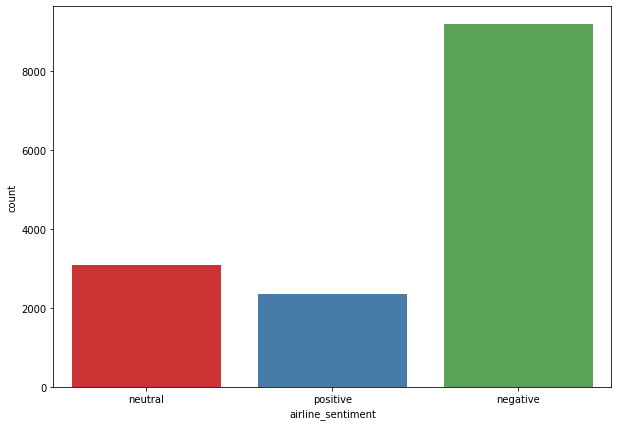

In [ ]:
# Unique values of sentiment plot
plt.figure(figsize=(10,7))
sns.countplot(x="airline_sentiment",palette="Set1" ,data=df)

> Positive and neutral tweets are almost equal.

> Negative tweets are more than double of neutral or positive sentiments.

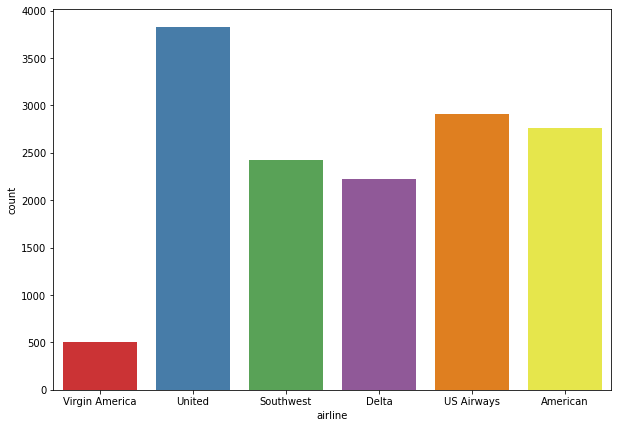

In [ ]:
# Unique values of airline

plt.figure(figsize=(10,7))
ax = sns.countplot(x="airline",palette="Set1", data=df)

> United has the most number of flights.

> Virgin America has the least.

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Utility Functions </h1>
</div>


In [ ]:
# I am tokenizing the tweet and also taking tokens from second index onwards as initital to gives airline name and '@' and lowering thm and later making it back a sentence
def clean_the_tweet(text):
  tokens= nltk.word_tokenize(re.sub("[^a-zA-Z]", " ",text))
  tokens = [token.lower() for token in tokens]
  return ' '.join(tokens[2:])

                 

def text_process(msg):
  nopunc =[char for char in msg if char not in string.punctuation]
  nopunc=''.join(nopunc)
  return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])


 
def check_scores(clf,X_train, X_test, y_train, y_test):

  model=clf.fit(X_train, y_train)
  predicted_class=model.predict(X_test)
  predicted_class_train=model.predict(X_train)
  test_probs = model.predict_proba(X_test)
  test_probs = test_probs[:, 1]
  yhat = model.predict(X_test)
  lr_precision, lr_recall, _ = precision_recall_curve(y_test, test_probs)
  lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)


  print(30*"=")
  print('Test confusion matrix is: ')

  cm2 = confusion_matrix(y_train, predicted_class_train)
  plt.rcParams['figure.figsize'] = [15,8]
  #confusion matrix to DataFrame
  conf_matrix2 = pd.DataFrame(data = cm2,columns = ['Predicted:0','Predicted:1',], index = ['Actual:0','Actual:1',])
  #plotting the confusion matrix
  sns.heatmap(conf_matrix2, annot = True, fmt = 'd', cmap = 'Paired', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
  plt.xticks(fontsize = 20)
  plt.yticks(fontsize = 20)
  plt.show()

  print(30*"=")
  print(classification_report(y_test,predicted_class)) 
  print(30*"=")
  train_accuracy = accuracy_score(y_train,predicted_class_train)
  test_accuracy = accuracy_score(y_test,predicted_class)

  print("Train accuracy score: ", train_accuracy)
  print("Test accuracy score: ",test_accuracy )
  print(30*"=")

  return train_accuracy, test_accuracy, s_train_auc, s_test_auc


def grid_search(model, parameters, X_train, Y_train):
  #Doing a grid
  grid = GridSearchCV(estimator=model,
                       param_grid = parameters,
                       cv = 2, verbose=2, scoring='roc_auc')
  #Fitting the grid 
  grid.fit(X_train,Y_train)
  print()
  print()
  # Best model found using grid search
  optimal_model = grid.best_estimator_
  print('Best parameters are: ')
  print( grid.best_params_)

  return optimal_model
  


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Text Preparation </h1>
</div>


In [ ]:
# removing neutral tweets

df = df[df['airline_sentiment']!='neutral']
df['cleaned_tweet'] = df['text'].apply(clean_the_tweet)

df.head()
df['airline_sentiment'] = df['airline_sentiment'].apply(lambda x: 1 if x =='positive' else 0)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude,cleaned_tweet
1,5.703011e+17,1,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025,you ve added commercials to the experience tacky
3,5.703010e+17,0,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135,s really aggressive to blast obnoxious enterta...
4,5.703008e+17,0,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752,it s a really big bad thing about it
5,5.703008e+17,0,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,36.226653,-119.290923,would pay a flight for seats that didn t have ...
6,5.703006e+17,1,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,33.778164,-119.565305,nearly every time i fly vx this ear worm won t...


In [ ]:
# Cleaning the tweets, removing punctuation marks
df['cleaned_tweet'] = df['cleaned_tweet'].apply(text_process)
df.reset_index(drop=True, inplace = True)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,latitude,longitude,cleaned_tweet
0,5.703011e+17,1,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,37.770971,-119.941025,added commercials experience tacky
1,5.703010e+17,0,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,37.061159,-119.279135,really aggressive blast obnoxious entertainmen...
2,5.703008e+17,0,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,36.790587,-120.867752,really big bad thing
3,5.703008e+17,0,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,36.226653,-119.290923,would pay flight seats playing really bad thin...
4,5.703006e+17,1,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,33.778164,-119.565305,nearly every time fly vx ear worm go away


In [ ]:
df['airline_sentiment'].unique()

array([1, 0])

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Base SVM model with TF-IDF </h1>
</div>


In [ ]:
# Creating object of TF-IDF vectorizer
vectorizer = TfidfVectorizer(use_idf=True, lowercase=True)
X_tff_idf= vectorizer.fit(df.cleaned_tweet)
X_tf_idf=vectorizer.transform(df.cleaned_tweet)
x_train, x_test, y_train, y_test = train_test_split(X_tf_idf, df['airline_sentiment'], random_state=42)


In [ ]:
pickle.dump(X_tff_idf, open("vectorizer.pickle", "wb")) 

Test confusion matrix is: 


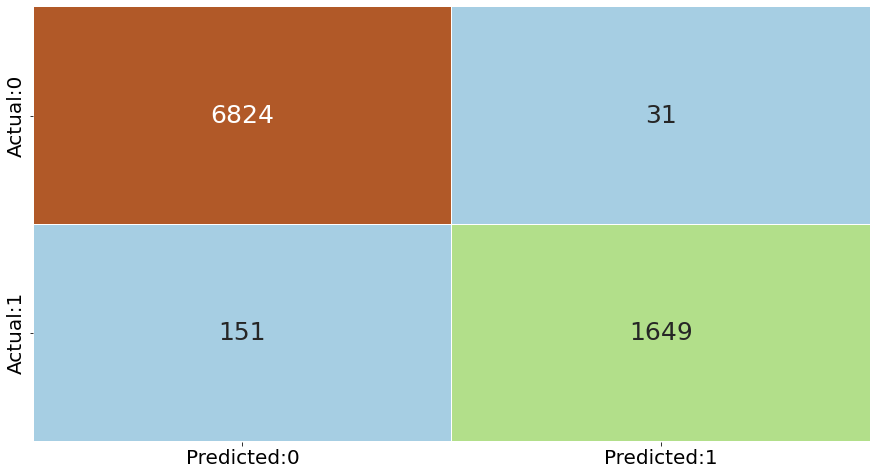

              precision    recall  f1-score   support

           0       0.89      0.99      0.93      2323
           1       0.89      0.47      0.62       563

    accuracy                           0.89      2886
   macro avg       0.89      0.73      0.78      2886
weighted avg       0.89      0.89      0.87      2886

Train accuracy score:  0.9789716926632005
Test accuracy score:  0.8863478863478863


In [ ]:
SVM = svm.SVC(probability=True)
s_train_accuracy, s_test_accuracy, s_train_auc, s_test_auc = check_scores(SVM,x_train, x_test, y_train, y_test)

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> After optimizing the hyperparameters with TF-IDF </h1>
</div>


In [ ]:
# Tuning the hyperparameters
parameters ={
    "C":[0.1,1,10],
    "kernel":['linear', 'rbf', 'sigmoid'],
    "gamma":['scale', 'auto']}

svm_optimal = grid_search(svm.SVC(probability=True), parameters,x_train, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   7.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   5.1s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   8.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   9.8s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   5.1s
[CV] END .................C=0.1, gamma=scale, kernel=sigmoid; total time=   4.9s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   5.1s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   4.9s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   5.4s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   4.3s
[CV] END ..................C=0.1, gamma=auto, kernel=sigmoid; total time=   3.7s
[CV] END ..................C=0.1, gamma=auto, ke

Test confusion matrix is: 


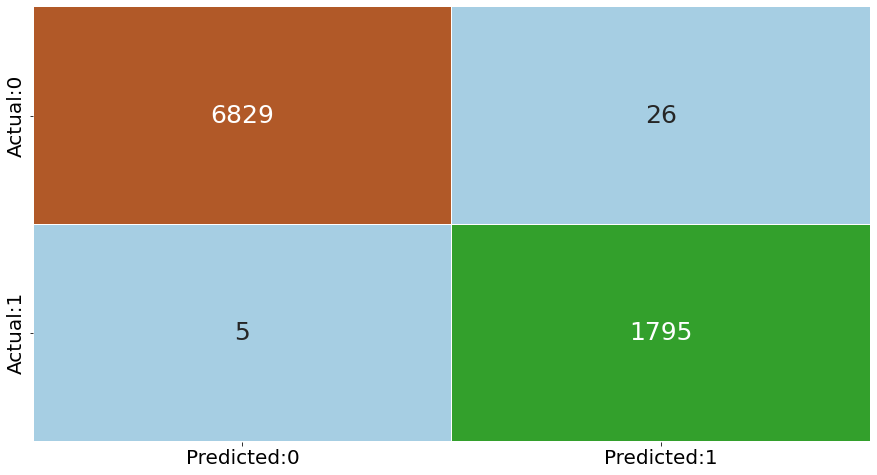

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2323
           1       0.86      0.56      0.68       563

    accuracy                           0.90      2886
   macro avg       0.88      0.77      0.81      2886
weighted avg       0.89      0.90      0.89      2886

Train accuracy score:  0.996418255343732
Test accuracy score:  0.8974358974358975


In [ ]:
so_train_accuracy, so_test_accuracy, so_train_auc, so_test_auc = check_scores(svm_optimal,x_train, x_test, y_train, y_test)

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using Multinomial Naive Bayes </h1>
</div>


Test confusion matrix is: 


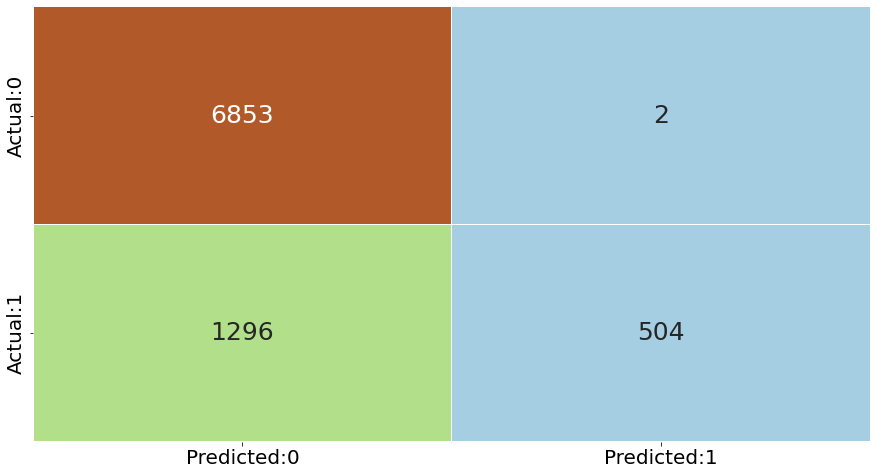

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.95      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886

Train accuracy score:  0.8500288850375506
Test accuracy score:  0.834026334026334


In [ ]:
m_train_accuracy, m_test_accuracy, m_train_auc, m_test_auc = check_scores(MultinomialNB(),x_train, x_test, y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using Gaussian Naive Bayes
 </h1>
</div>


Test confusion matrix is: 


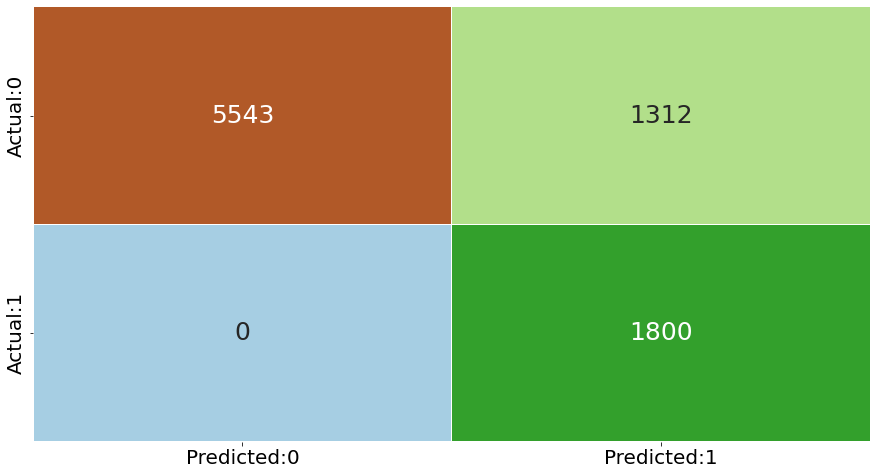

              precision    recall  f1-score   support

           0       0.90      0.70      0.79      2323
           1       0.35      0.68      0.46       563

    accuracy                           0.69      2886
   macro avg       0.63      0.69      0.63      2886
weighted avg       0.79      0.69      0.72      2886

Train accuracy score:  0.8484113229347198
Test accuracy score:  0.6947331947331947


In [ ]:
g_train_accuracy, g_test_accuracy, g_train_auc, g_test_auc=check_scores(GaussianNB(),x_train.toarray(), x_test.toarray(), y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Using AdaBoost
 </h1>
</div>


Test confusion matrix is: 


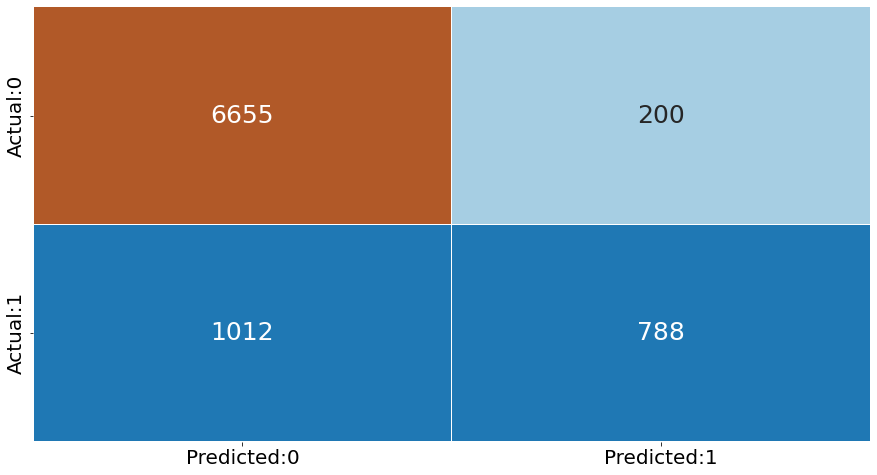

              precision    recall  f1-score   support

           0       0.87      0.97      0.92      2323
           1       0.77      0.42      0.54       563

    accuracy                           0.86      2886
   macro avg       0.82      0.69      0.73      2886
weighted avg       0.85      0.86      0.84      2886

Train accuracy score:  0.8599653379549393
Test accuracy score:  0.8613998613998614


In [ ]:
a_train_accuracy, a_test_accuracy, a_train_auc, a_test_auc=check_scores(AdaBoostClassifier(),x_train,x_test, y_train, y_test)


In [ ]:
params = {'n_estimators': [10, 50, 100, 500],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
 'algorithm': ['SAMME', 'SAMME.R']}

ada_optimal_model = grid_search(AdaBoostClassifier(), params,x_train, y_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=10; total time=   0.3s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   1.1s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=50; total time=   1.1s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   2.3s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=100; total time=   2.2s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  12.2s
[CV] END algorithm=SAMME, learning_rate=0.0001, n_estimators=500; total time=  11.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=10; total time=   0.2s
[CV] END algorithm=SAMME, learning_rate=0.001, n_estimators=50; total time=   1.1s
[CV] END algor

Test confusion matrix is: 


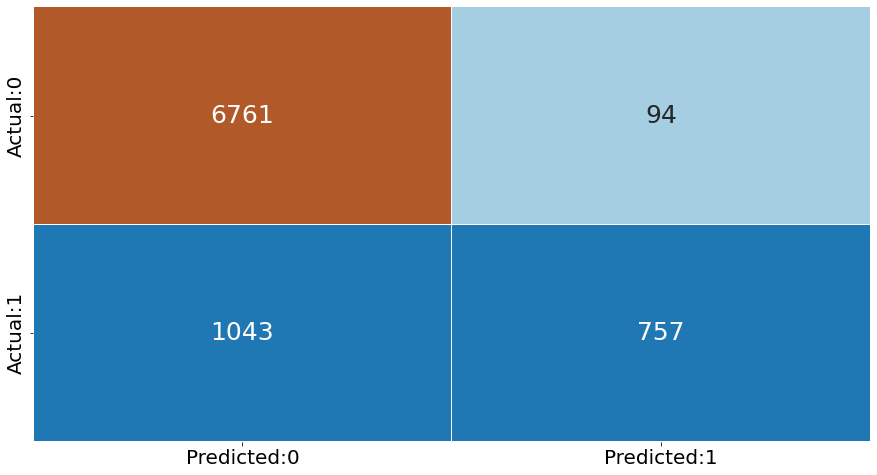

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2323
           1       0.83      0.40      0.54       563

    accuracy                           0.87      2886
   macro avg       0.85      0.69      0.73      2886
weighted avg       0.86      0.87      0.85      2886

Train accuracy score:  0.868630849220104
Test accuracy score:  0.8665973665973666


In [ ]:
ao_train_accuracy, ao_test_accuracy, ao_train_auc, ao_test_auc=check_scores(ada_optimal_model,x_train,x_test, y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold"> Bagging with MultinomialNB
 </h1>
</div>


Test confusion matrix is: 


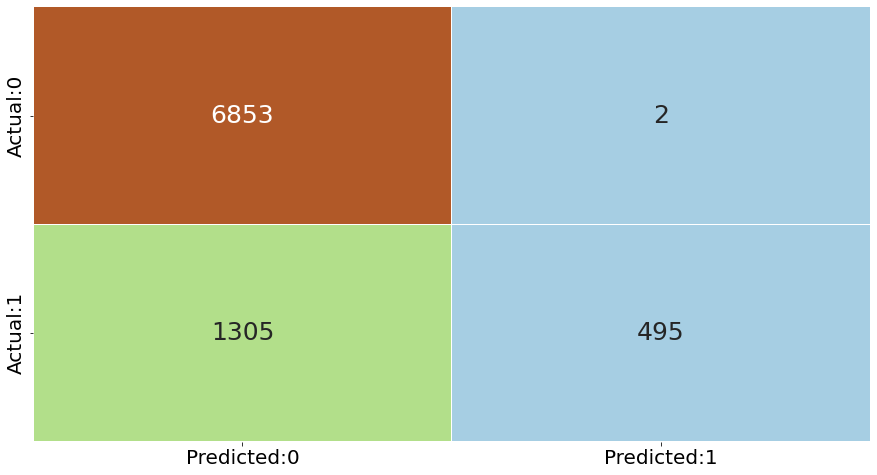

              precision    recall  f1-score   support

           0       0.83      1.00      0.91      2323
           1       0.96      0.16      0.27       563

    accuracy                           0.83      2886
   macro avg       0.89      0.58      0.59      2886
weighted avg       0.85      0.83      0.78      2886

Train accuracy score:  0.8489890236857308
Test accuracy score:  0.834026334026334


In [ ]:
kfold = model_selection.KFold(n_splits = 3)
  
# bagging classifier
model = BaggingClassifier(base_estimator = MultinomialNB(),
                          n_estimators = 100)

b_train_accuracy, b_test_accuracy, b_train_auc, b_test_auc= check_scores(model,x_train,x_test, y_train, y_test)


<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Using Random Forest
 </h1>
</div>



Test confusion matrix is: 


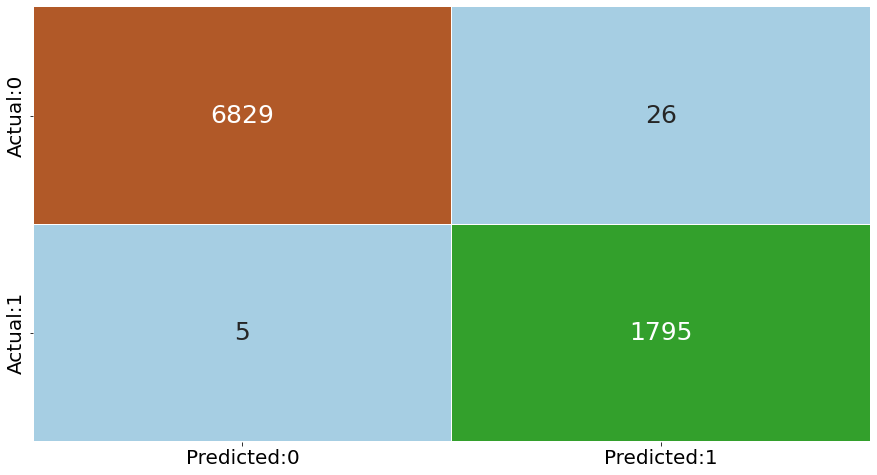

              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2323
           1       0.75      0.58      0.65       563

    accuracy                           0.88      2886
   macro avg       0.83      0.77      0.79      2886
weighted avg       0.87      0.88      0.87      2886

Train accuracy score:  0.996418255343732
Test accuracy score:  0.8801108801108801


In [ ]:
r_train_accuracy, r_test_accuracy, r_train_auc, r_test_auc= check_scores(RandomForestClassifier(random_state=0).fit(x_train, y_train), x_train,x_test,y_train,y_test)

<div style="color:white;
           display:fill;
           border-radius:5px;
           font-size:110%;
           font-family:cursive;
           letter-spacing:0.5px;
           background-color:powderblue;
           color:Black;
           font-family:cursive
           ">
<h1 style="text-align:center;font-weight: bold">Final Results
 </h1>
</div>



In [ ]:
data = [('Random Forest', r_train_accuracy, r_test_accuracy),
 ('MultinomialNB',m_train_accuracy, m_test_accuracy ),
('Bagged MultinomialNB',b_train_accuracy, b_test_accuracy ),
 ('AdaBoost',a_train_accuracy, a_test_accuracy),
('AdaBoost Optimized',ao_train_accuracy, ao_test_accuracy),
('Gaussian Naive Bayes',g_train_accuracy, g_test_accuracy),
('SVM', s_train_accuracy, s_test_accuracy),
('SVM Optimized', so_train_accuracy, so_test_accuracy)]


Scores_ =pd.DataFrame(data = data, columns=['Model Name','Train Accuracy', 'Test Accuracy'])
Scores_.set_index('Model Name', inplace = True)

Scores_

,Train Accuracy,Test Accuracy
Model Name,,
Random Forest,0.996418,0.880111
MultinomialNB,0.850029,0.834026
Bagged MultinomialNB,0.848989,0.834026
AdaBoost,0.859965,0.861400
AdaBoost Optimized,0.868631,0.866597
Gaussian Naive Bayes,0.848411,0.694733
SVM,0.978972,0.886348
SVM Optimized,0.996418,0.897436


# **Checking our Model**

In [ ]:
sv_opt=svm.SVC(probability=True, C=10, kernel='rbf', gamma='scale')
check="@AmericanAir Trying to rebook a flight with you because of Cancelled Flightlation is a nightmare. I was hung up on once. Can you help me rebook?"
clean_cheeck=clean_the_tweet(check)
vectorizer = pickle.load(open("vectorizer.pickle", 'rb'))
new=vectorizer.transform([clean_cheeck])
fit_model=sv_opt.fit(x_train, y_train)
result=fit_model.predict(new)
if result[0]==0:
  print('Negative')
else:
  print("Positive") 


Negative


**Awesome .... it works great** 

In [ ]:
pickle.dump(fit_model, open("fit_model.pickle", "wb")) 